The Notebook should be run from the top to bottom. Block 2 is the data processing part in section 3.2, block 3 is the starter file code (section 3.3). Block 4 contains the model set up and training function, while block 5 is the main function to actual process the data to dataloders. Block 6 corrospondes to section 4.4, block 7,8 corrospondes to section 4.5, and the last block corrospondes to section 4.6.\
When there's a need to change batch size, rerun block 5 with appropriate batch size. Other parameters can be tuned when calling the training function in block 6 and 7

In [1]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
# Read TSV file into DataFrame
df = pd.read_csv('data/data.tsv', sep='\t')
data_list = df.values.tolist()
text_list = df["text"].tolist()
label_list = df["label"].tolist()
#ensure balanced class using stratify parameter
X_train, X_val_test, y_train, y_val_test = train_test_split(text_list, label_list, test_size=0.36, stratify = label_list, random_state=6)
print(y_train.count(0), y_train.count(1)) # 3200, 3200
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=(20/36), stratify = y_val_test, random_state=6)
print(y_val.count(0), y_val.count(1)) # 800, 800
print(y_test.count(0), y_test.count(1)) # 1000, 1000
print(len(X_train), len(X_val), len(X_test)) # 6400, 1600, 2000
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_df.to_csv('data/train.tsv', sep='\t', index=False)
validation_df = pd.DataFrame({'text': X_val, 'label': y_val})
validation_df.to_csv('data/validation.tsv', sep='\t', index=False)
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_df.to_csv('data/test.tsv', sep='\t', index=False)

X_overfit, X_other, y_overfit, y_other = train_test_split(text_list, label_list, test_size=0.995, stratify = label_list, random_state=6)
print(len(X_overfit), y_overfit.count(0), y_overfit.count(1)) # 50 25 25
overfit_df = pd.DataFrame({'text': X_overfit, 'label': y_overfit})
overfit_df.to_csv('data/overfit.tsv', sep='\t', index=False)

3200 3200
800 800
1000 1000
6400 1600 2000
50 25 25


In [3]:
# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    # Change made here, to make the X_batch of size (batch_size, word_indicies_len)
    #return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)
    return torch.stack(batch_x).int().to(device), torch.tensor(batch_y).to(device)

In [31]:
class BaselineModel(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.linear = nn.Linear(len(vocab.vectors[0]), 1)

    def forward(self, x):
        # x shape: (batch_size, word_indicies_len)
        # get the embeddings first
        embeddings = self.embedding(x)
        # embedding shape: (batch_size, word_indicies_len, embedding_size)
        average = torch.mean(embeddings, dim=1) # take the average of all the word embeddings in the sentence
        # average shape: (batch_size, embedding_size)
        prediction = self.linear(average)
        return prediction

def train_baseline(vocab, train_dataloader, validation_dataloader, device, num_epochs=50, lr=0.001):
  num_epochs = num_epochs
  lr = lr

  # instantiate the model & set up the optimizer
  model = BaselineModel(vocab)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # loss function
  criterion = nn.BCEWithLogitsLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  max_val_accuracy = 0
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct_labels = 0.0
    num_training_examples = 0

    for word_indicies, labels in train_dataloader:
      optimizer.zero_grad()
      predictions = model.forward(word_indicies)
      predictions = predictions.to(torch.float32).squeeze()
      labels = labels.to(torch.float32)
      loss = criterion(predictions, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      # also need to calculate the accuracy
      # > 0.5 -> label 1 and <= 0.5 -> label 0
      predictions = torch.round(torch.sigmoid(predictions))
      num_training_examples += len(predictions)
      num_correct_labels = (predictions == labels).sum().item()
      train_correct_labels += num_correct_labels
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_correct_labels / num_training_examples)

    model.eval()
    val_loss = 0.0
    val_correct_labels = 0.0
    num_validation_examples = 0
    with torch.no_grad():
      for word_indicies, labels in validation_dataloader:
        predictions = model.forward(word_indicies)
        predictions = predictions.to(torch.float32).squeeze()
        labels = labels.to(torch.float32)
        loss = criterion(predictions, labels)
        val_loss += loss.item()
        predictions = torch.round(torch.sigmoid(predictions))
        num_validation_examples += len(predictions)
        num_correct_labels = (predictions == labels).sum().item()
        val_correct_labels += num_correct_labels
    val_losses.append(val_loss / len(validation_dataloader))
    val_accuracies.append(val_correct_labels / num_validation_examples)
    if (val_accuracies[-1] > max_val_accuracy):
      max_val_accuracy = val_accuracies[-1]
      torch.save(model.state_dict(), 'model_baseline.pt')
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}" )
  return model, train_losses, val_losses, train_accuracies, val_accuracies


In [32]:
def main(batch_size):
  #   fix seed
  torch.manual_seed(2)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  ### 3.3 Processing of the data ###
  # 3.3.1
  # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
  glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

  # 3.3.2

  train_dataset = TextDataset(glove, "train")
  val_dataset = TextDataset(glove, "validation")
  test_dataset = TextDataset(glove, "test")
  overfit_dataset = TextDataset(glove, "overfit")

  # 3.3.3
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  overfit_dataloader = torch.utils.data.DataLoader(
      dataset=overfit_dataset,
      batch_size=batch_size,
      shuffle=False,
      collate_fn=lambda batch: my_collate_function(batch, device))

  return glove, train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, device

  # Instantiate your model(s) and train them and so on
  # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
  # so that it is easier to experiment with
batch_size = 4
glove, train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, device = main(batch_size)

Using device: cuda


Using device: cuda
Epoch [1/50] - Train Loss: 0.6986, Train Accuracy: 0.5400, Validation Loss: 0.7130, Validation Accuracy: 0.5000
Epoch [2/50] - Train Loss: 0.7235, Train Accuracy: 0.4800, Validation Loss: 0.6408, Validation Accuracy: 0.6737
Epoch [3/50] - Train Loss: 0.6088, Train Accuracy: 0.7400, Validation Loss: 0.6156, Validation Accuracy: 0.6894
Epoch [4/50] - Train Loss: 0.6056, Train Accuracy: 0.6800, Validation Loss: 0.5910, Validation Accuracy: 0.7681
Epoch [5/50] - Train Loss: 0.5653, Train Accuracy: 0.8000, Validation Loss: 0.5728, Validation Accuracy: 0.7931
Epoch [6/50] - Train Loss: 0.5472, Train Accuracy: 0.8000, Validation Loss: 0.5562, Validation Accuracy: 0.8050
Epoch [7/50] - Train Loss: 0.5228, Train Accuracy: 0.8200, Validation Loss: 0.5419, Validation Accuracy: 0.8144
Epoch [8/50] - Train Loss: 0.5044, Train Accuracy: 0.8800, Validation Loss: 0.5291, Validation Accuracy: 0.8175
Epoch [9/50] - Train Loss: 0.4859, Train Accuracy: 0.9000, Validation Loss: 0.5179, V

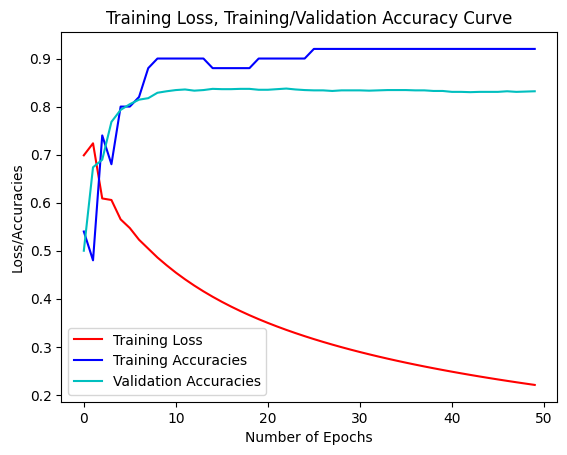

In [ ]:
#Q4.4
model, train_losses, val_losses, train_accuracies, val_accuracies = train_baseline(glove, overfit_dataloader, validation_dataloader, device, lr = 0.03)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_losses, 'r', label='Training Loss')
ax.plot(train_accuracies, 'b', label='Training Accuracies')
ax.plot(val_accuracies, 'c', label='Validation Accuracies')

# Set labels and legend
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training Loss, Training/Validation Accuracy Curve')
ax.legend()

# Show the plot
plt.show()

Epoch [1/50] - Train Loss: 0.6093, Train Accuracy: 0.7583, Validation Loss: 0.5356, Validation Accuracy: 0.8425
Epoch [2/50] - Train Loss: 0.4922, Train Accuracy: 0.8509, Validation Loss: 0.4576, Validation Accuracy: 0.8525
Epoch [3/50] - Train Loss: 0.4330, Train Accuracy: 0.8609, Validation Loss: 0.4144, Validation Accuracy: 0.8550
Epoch [4/50] - Train Loss: 0.3981, Train Accuracy: 0.8655, Validation Loss: 0.3873, Validation Accuracy: 0.8588
Epoch [5/50] - Train Loss: 0.3754, Train Accuracy: 0.8688, Validation Loss: 0.3690, Validation Accuracy: 0.8631
Epoch [6/50] - Train Loss: 0.3594, Train Accuracy: 0.8723, Validation Loss: 0.3556, Validation Accuracy: 0.8644
Epoch [7/50] - Train Loss: 0.3475, Train Accuracy: 0.8747, Validation Loss: 0.3455, Validation Accuracy: 0.8656
Epoch [8/50] - Train Loss: 0.3383, Train Accuracy: 0.8756, Validation Loss: 0.3374, Validation Accuracy: 0.8675
Epoch [9/50] - Train Loss: 0.3309, Train Accuracy: 0.8770, Validation Loss: 0.3309, Validation Accuracy:

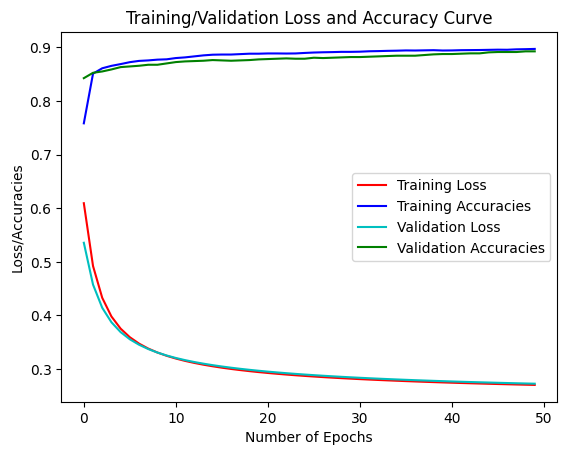

In [33]:
#Q4.5
model, train_losses, val_losses, train_accuracies, val_accuracies = train_baseline(glove, train_dataloader, validation_dataloader, device, lr = 0.001)

fig, ax = plt.subplots()

# Plot training and validation losses
ax.plot(train_losses, 'r', label='Training Loss')
ax.plot(train_accuracies, 'b', label='Training Accuracies')
ax.plot(val_losses, 'c', label='Validation Loss')
ax.plot(val_accuracies, 'g', label='Validation Accuracies')

# Set labels and legend
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss/Accuracies')
ax.set_title('Training/Validation Loss and Accuracy Curve')
ax.legend()

# Show the plot
plt.show()

In [34]:
#Test accuracy
model.eval()
test_correct_labels = 0
num_test_examples = 0
with torch.no_grad():
  for word_indicies, labels in test_dataloader:
    predictions = model.forward(word_indicies).squeeze()
    predictions = torch.round(torch.sigmoid(predictions))
    num_test_examples += len(predictions)
    num_correct_labels = (predictions == labels).sum().item()
    test_correct_labels += num_correct_labels
test_accuracy = test_correct_labels / num_test_examples
print("Final Test Accuracy is", test_accuracy)

Final Test Accuracy is 0.897


In [35]:
def print_closest_cosine_words(vec, n=20):
    similarities = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0))   # compute similarities to all words
    lst = sorted(enumerate(similarities.numpy()), key=lambda x: x[1], reverse=True) # sort by similarities in descending order
    for idx, similarity in lst[0:n]:  # take the top n
        print(glove.itos[idx], "\t%5.2f" % similarity)
#get the weights from the linear layer and feed into the functions to find closest words
model_weights = model.linear.weight.detach().squeeze().to(torch.device("cpu"))
print_closest_cosine_words(model_weights, 20)

insipid 	 0.54
flattering 	 0.53
pleasing 	 0.53
campy 	 0.53
visuals 	 0.53
watchable 	 0.53
simplistic 	 0.52
underwhelming 	 0.51
verbiage 	 0.51
emptier 	 0.50
mesmerizing 	 0.50
nuanced 	 0.50
laughable 	 0.50
appetizing 	 0.49
tepid 	 0.49
funnily 	 0.49
cartoony 	 0.49
glib 	 0.48
wrongheaded 	 0.48
engrossing 	 0.48
